# Problem-Specific Coordinate Generation for HyperNEAT Substrates

# Part 2: Substrate Generation

In this second part, the substrates are generated using different methods based on the previously saved sampled data.

## Setup

### Imports

In [1]:
import pickle
from collections import defaultdict

import matplotlib.pyplot as plt

from config import config

from tensorneat.algorithm.hyperneat import FullSubstrate

from substrate_generation.pca_coor_generator import PCAanalyzer 
from substrate_generation.pca_inv_coor_generator import InvPCAanalyzer 
from substrate_generation.dl_coor_generator import DictionaryAnalyzer
from substrate_generation.fa_coor_generator import FactorAnalyzer
from substrate_generation.manual_coor_generator import ManualIOMapper
from substrate_generation.random_coor_generator import RandomCoordinateGenerator
from substrate_generation.ica_generator import ICAanalyzer 
from substrate_generation.isomap_coor_generator import IsomapIOEmbedder
from substrate_generation.hidden_layers import HiddenLayerGenerator

from evol_pipeline.brax_env import CustomBraxEnv

from utils.visualization import display_plots_side_by_side
from utils.utils import setup_folders_substrate, load_data_sources, save_coordinates_to_csv

The folder structure is checked to avoid problems when saving files.

In [2]:
OUTPUT_DIR = config["experiment"]["output_dir_substrates"]
setup_folders_substrate(OUTPUT_DIR)

The environment needs to be setup to get values like obs_size and act_size.

In [3]:
env_name = config["experiment"]["env_name"]
env_problem = CustomBraxEnv(
    env_name=env_name,
    backend=config["environment"]["backend"],
    brax_args=config["environment"]["brax_args"],
    max_step=config["environment"]["max_step"],
    repeat_times=config["environment"]["repeat_times"],
    obs_normalization=config["environment"]["obs_normalization"],
    sample_episodes=config["environment"]["sample_episodes"],
)
obs_size = env_problem.input_shape[0]
act_size = env_problem.output_shape[0]
feature_dims_repeats = config["data_analysis"]["feature_dims"]

/home/andi/anaconda3/envs/jax/lib/python3.10/site-packages/brax/io/mjcf.py:480: UserWarning: Brax System, piplines and environments are not actively being maintained. Please see MJX for a well maintained JAX-based physics engine: https://github.com/google-deepmind/mujoco/tree/main/mjx. For a host of environments that use MJX, see: https://github.com/google-deepmind/mujoco_playground.
  warnings.warn(
2025-11-13 08:12:44.408320: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-11-13 08:12:55.359768: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by usin

The data_sources previously saved to disk are used for analysis.

In [4]:
data_sources = load_data_sources(config["experiment"]["data_sources_path"])

Successfully loaded data sources from: data_sources.npz


## Data Analysis

Next, it's time to analyse the sampled data. The goal is to find correlations in the data which can be used to assign substrate coordinates. Again, different methods are used for comparison, namely Principal Component Analysis (PCA), Factor Analysis (FA) and Dictionary Learning (DL). These methods will be applied to both data samples.

In this first step, the analysis methods will be used to produce input and output coordinates only. The hidden layers are generated later.

All results are stored in a single dictionary object which is defined first.

In [5]:
def deep_defaultdict():
    return defaultdict(deep_defaultdict)

generated_io_coors = deep_defaultdict()

### ICA

Independent Component Analysis (ICA) is used to defined components with maximal statistical indidepence. As you can read in the [scikit-learn documentation](https://scikit-learn.org/stable/modules/decomposition.html#independent-component-analysis-ica): "Typically, ICA is not used for reducing dimensionality but for separating superimposed signals."


Analyzing 'trained' data with ICA (24 dims)
Running Independent Component Analysis (ICA) to find 24 components...
ICA complete. Extracting coordinates (component loadings).
Normalizing coordinates...
Added layering dimension. Final coordinate size: 25


/home/andi/anaconda3/envs/jax/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Independent component heatmap saved to: output_substrates/data_analysis/ica_heatmap_trained_24fd.png



Analyzing 'random' data with ICA (24 dims)
Running Independent Component Analysis (ICA) to find 24 components...


/home/andi/anaconda3/envs/jax/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


ICA complete. Extracting coordinates (component loadings).
Normalizing coordinates...
Added layering dimension. Final coordinate size: 25
Independent component heatmap saved to: output_substrates/data_analysis/ica_heatmap_random_24fd.png




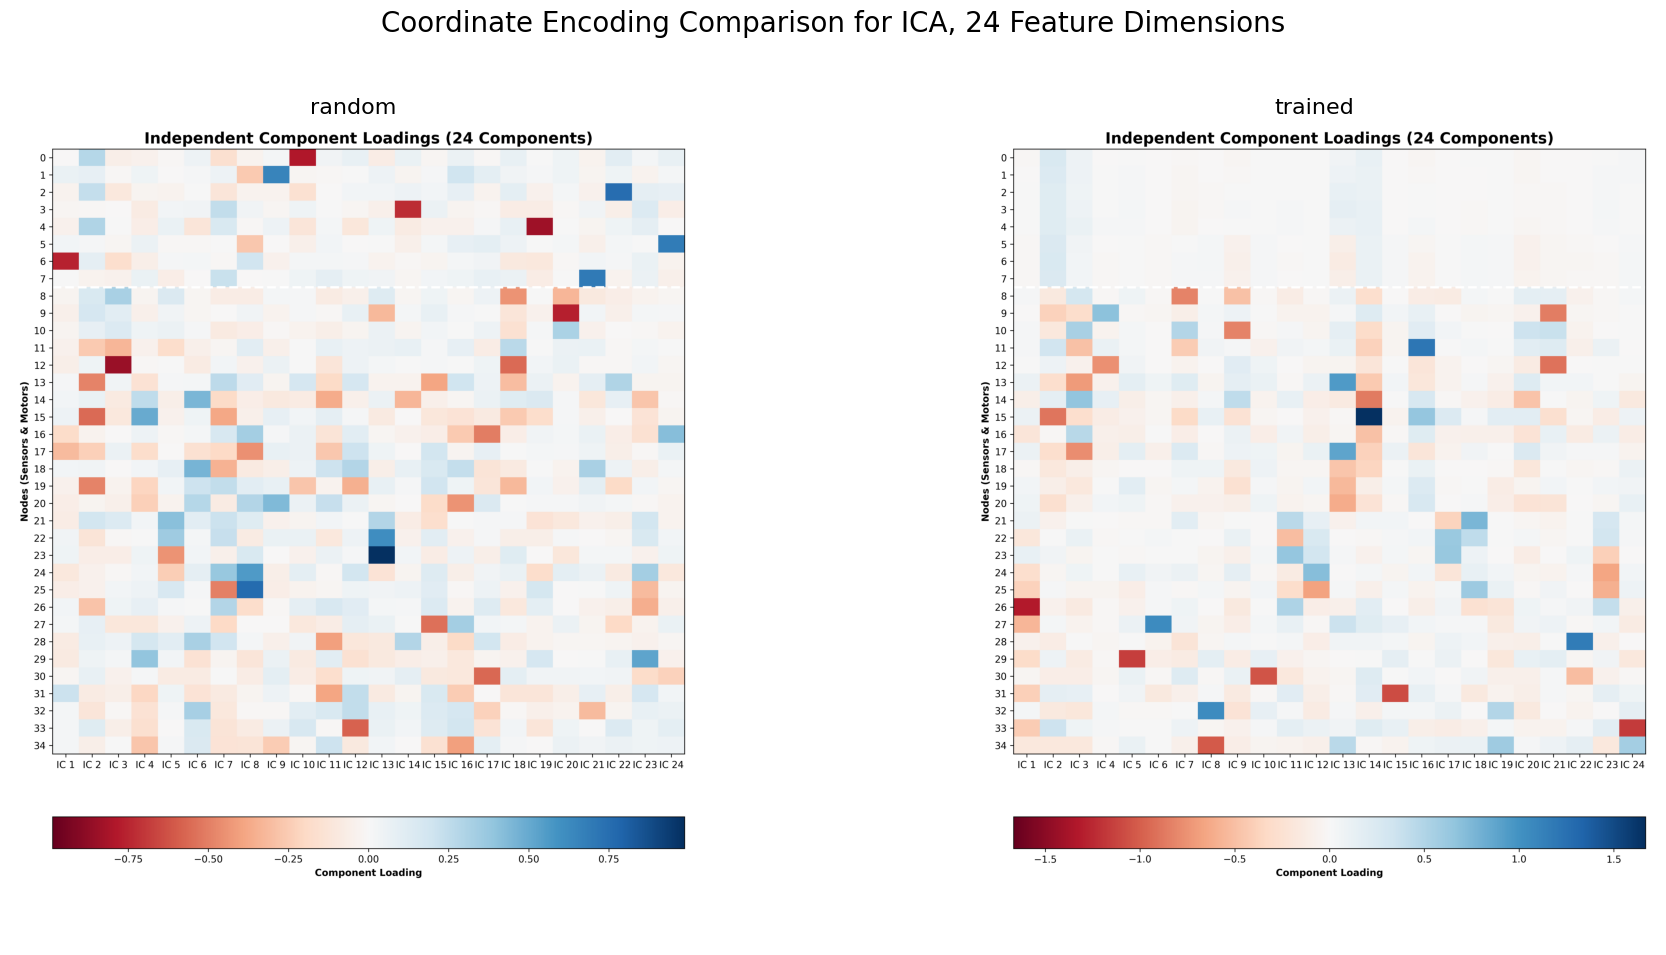

In [6]:
for feature_dims in feature_dims_repeats:
    for data_label, data_array in data_sources.items():

        print(f"\nAnalyzing '{data_label}' data with ICA ({feature_dims} dims)")
        analyzer_ica = ICAanalyzer(
            data=data_array, 
            obs_size=obs_size, 
            act_size=act_size,
            feature_dims=feature_dims,
            width_factor=config["substrate"]["width_factor"],
            normalize_coors=config["data_analysis"]["normalize_coors"],
            depth_factor=config["substrate"]["depth_factor"],
            seed=config["experiment"]["seed"]
        )
        input_coors_ica, output_coors_ica = analyzer_ica.generate_io_coordinates()
        generated_io_coors[data_label]["ica"][f"{feature_dims}fd"]["input_coors"] = input_coors_ica
        generated_io_coors[data_label]["ica"][f"{feature_dims}fd"]["output_coors"] = output_coors_ica
        analyzer_ica.plot_independent_components(save_path=f"{OUTPUT_DIR}/data_analysis/ica_heatmap_{data_label}_{feature_dims}fd.png")
        print("\n")

    display_plots_side_by_side(
        plot_paths=[f"{OUTPUT_DIR}/data_analysis/ica_heatmap_random_{feature_dims}fd.png", f"{OUTPUT_DIR}/data_analysis/ica_heatmap_trained_{feature_dims}fd.png"],
        plot_titles=["random", "trained"],
        main_title=f"Coordinate Encoding Comparison for ICA, {feature_dims} Feature Dimensions",
        save_path=f"{OUTPUT_DIR}/data_analysis/ica_heatmap_comparison_{feature_dims}fd.png"
    )

### PCA

Principal Component Analysis (PCA) is commonly used for dimensionality reduction and using Singular Value Decomposition of the data to project it to a lower dimensional space. The [scikit-learn implementation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) of PCA is used here.

Analyzing trained sampling data
Running PCA to find feature dimensions covering 100.0% of variance (with a hard limit of 24 dimensions)...
PCA found 24 dimensions needed for 100.0% variance.
Applying max limit. Final number of feature dimensions: 24
Normalizing coordinates...
Added layering dimension. Final coordinate size: 25
PCA variance plot saved to: output_substrates/data_analysis/pca_variance_trained_24fd.png
Principal component heatmap saved to: output_substrates/data_analysis/pca_heatmap_trained_24fd.png


Analyzing random sampling data
Running PCA to find feature dimensions covering 100.0% of variance (with a hard limit of 24 dimensions)...
PCA found 24 dimensions needed for 100.0% variance.
Applying max limit. Final number of feature dimensions: 24
Normalizing coordinates...
Added layering dimension. Final coordinate size: 25
PCA variance plot saved to: output_substrates/data_analysis/pca_variance_random_24fd.png
Principal component heatmap saved to: output_substrates/data_an

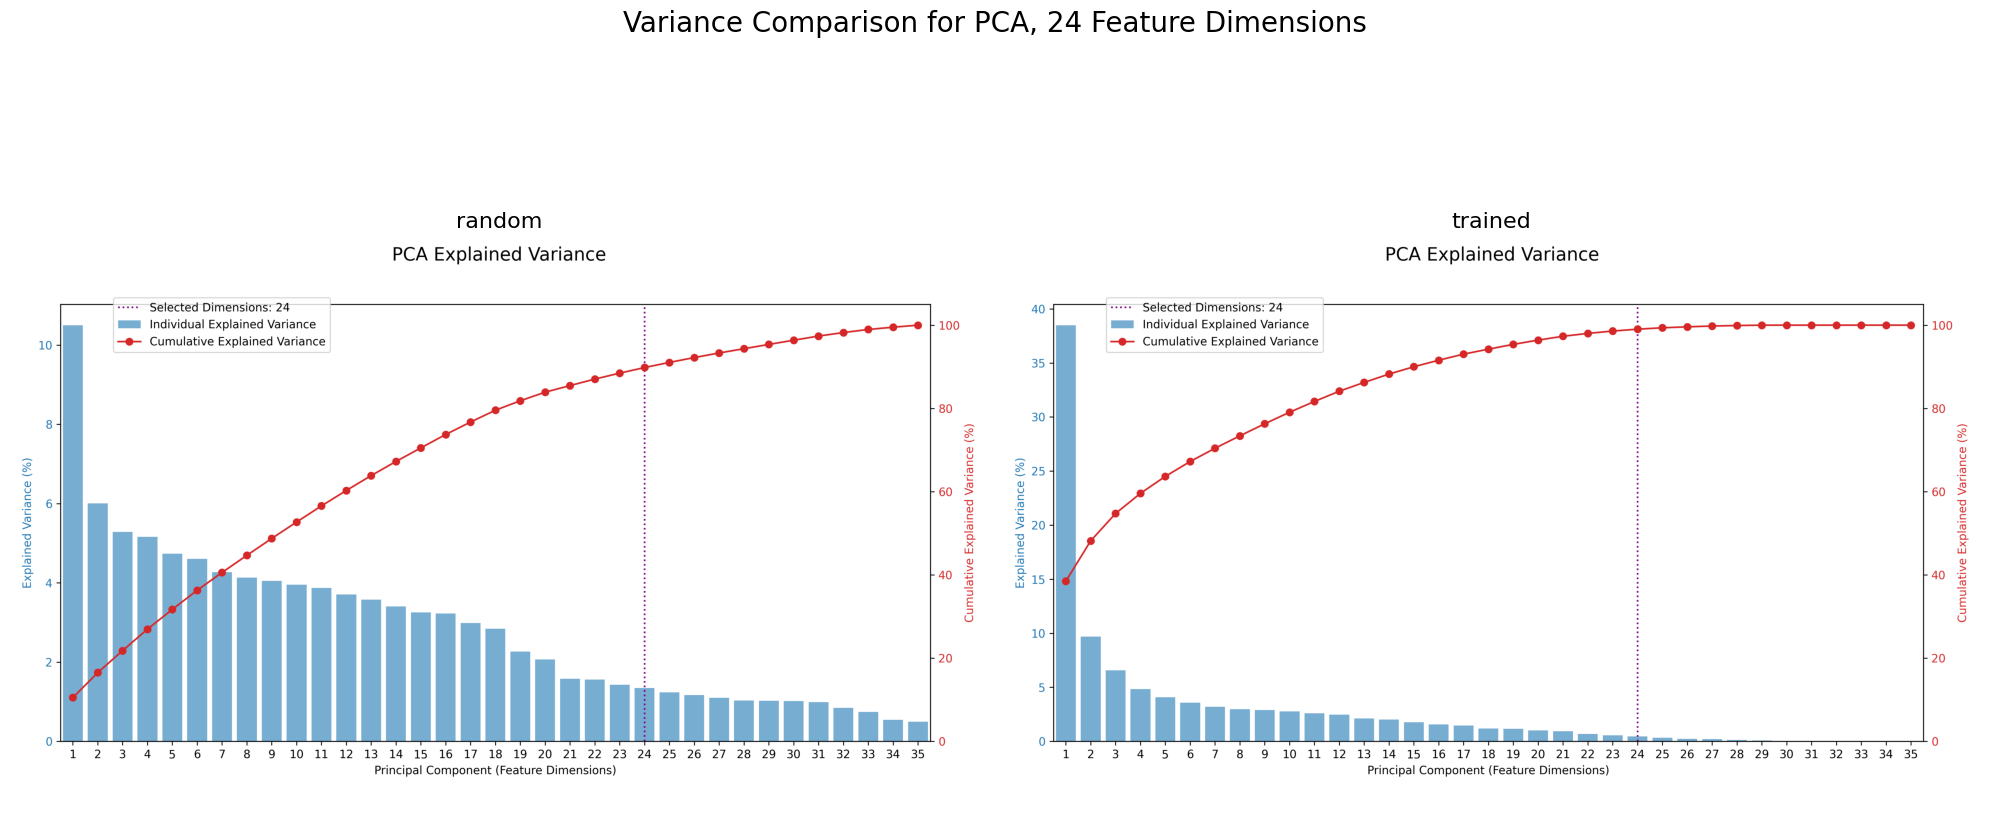

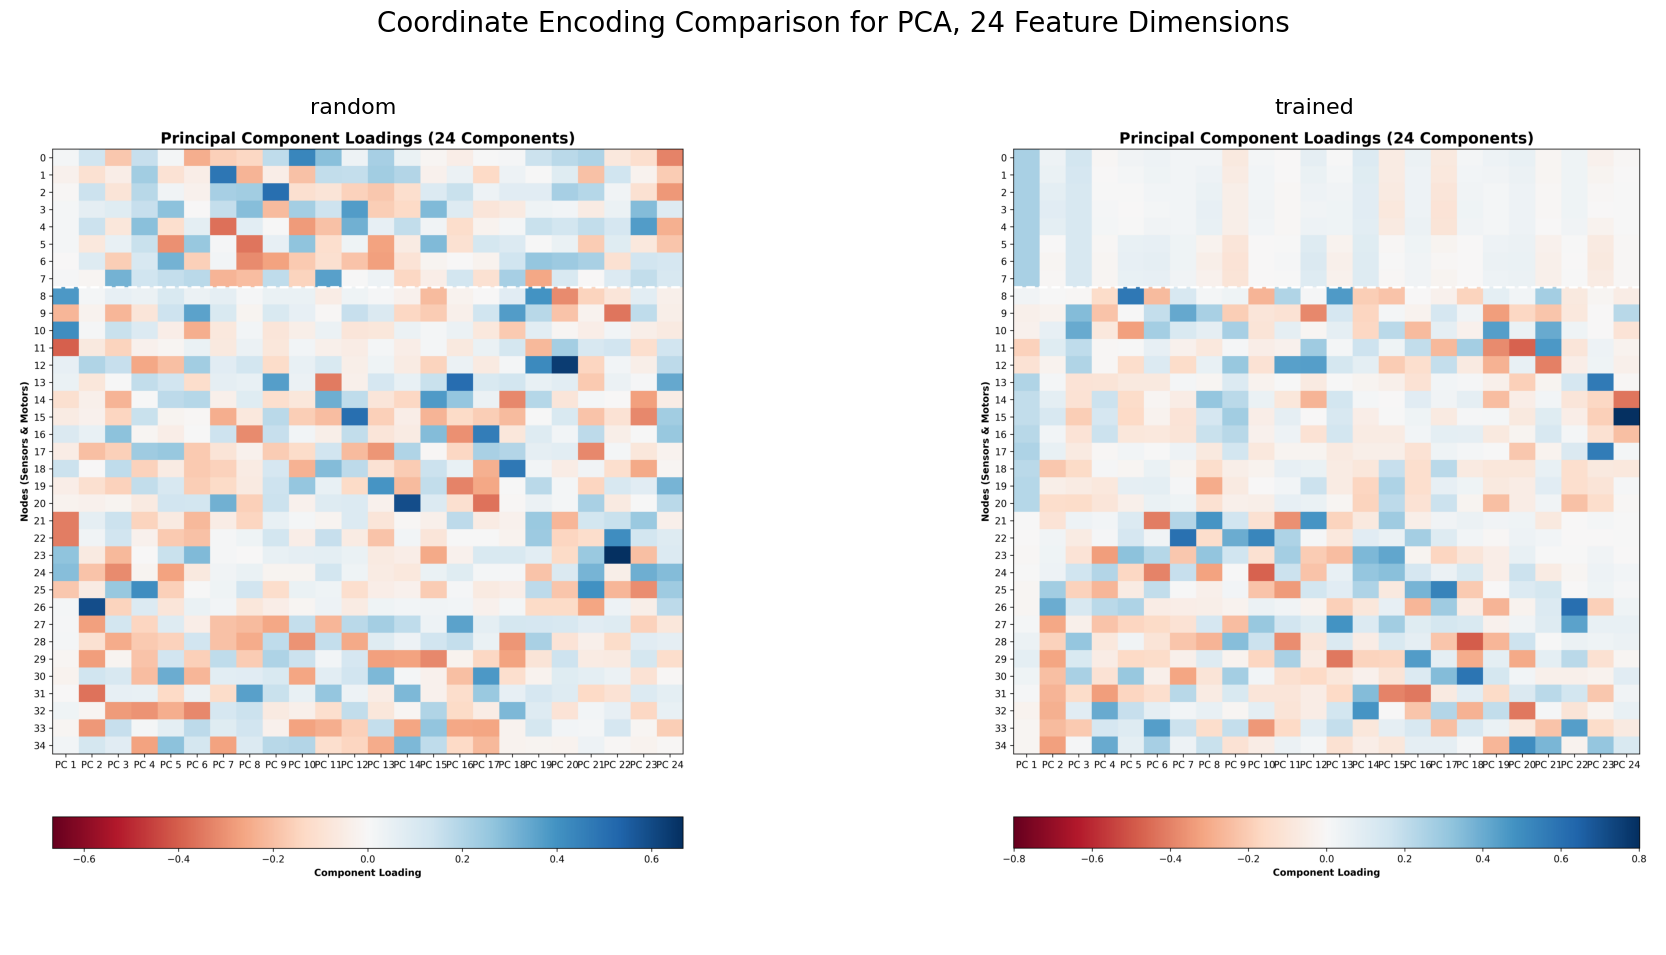

In [7]:
for feature_dims in feature_dims_repeats:
    for data_label, data_array in data_sources.items():

        print(f"Analyzing {data_label} sampling data")
        analyzer_pca = PCAanalyzer(
            data=data_array, 
            obs_size=obs_size, 
            act_size=act_size,
            variance_threshold=config["data_analysis"]["variance_threshold"], 
            feature_dims=feature_dims,
            width_factor=config["substrate"]["width_factor"],
            normalize_coors=config["data_analysis"]["normalize_coors"],
            depth_factor=config["substrate"]["depth_factor"],
        )
        input_coors_pca, output_coors_pca = analyzer_pca.generate_io_coordinates()
        generated_io_coors[data_label]["pca"][f"{feature_dims}fd"]["input_coors"] = input_coors_pca
        generated_io_coors[data_label]["pca"][f"{feature_dims}fd"]["output_coors"] = output_coors_pca
        analyzer_pca.plot_variance(save_path=f"{OUTPUT_DIR}/data_analysis/pca_variance_{data_label}_{feature_dims}fd.png")
        analyzer_pca.plot_principal_components(save_path=f"{OUTPUT_DIR}/data_analysis/pca_heatmap_{data_label}_{feature_dims}fd.png")
        print("\n")

    display_plots_side_by_side(
        plot_paths=[f"{OUTPUT_DIR}/data_analysis/pca_variance_random_{feature_dims}fd.png", f"{OUTPUT_DIR}/data_analysis/pca_variance_trained_{feature_dims}fd.png"],
        plot_titles=["random", "trained"],
        main_title=f"Variance Comparison for PCA, {feature_dims} Feature Dimensions",
        save_path=f"{OUTPUT_DIR}/data_analysis/pca_variance_comparison_{feature_dims}fd.png"
    )
    display_plots_side_by_side(
        plot_paths=[f"{OUTPUT_DIR}/data_analysis/pca_heatmap_random_{feature_dims}fd.png", f"{OUTPUT_DIR}/data_analysis/pca_heatmap_trained_{feature_dims}fd.png"],
        plot_titles=["random", "trained"],
        main_title=f"Coordinate Encoding Comparison for PCA, {feature_dims} Feature Dimensions",
        save_path=f"{OUTPUT_DIR}/data_analysis/pca_heatmap_comparison_{feature_dims}fd.png"
    )

To measure the effect of PC selection by variance, another baseline with inversed variance selection is established. It means that in this case, the PCs with the least variance are chosen for coordinate generation.

Analyzing trained sampling data with PCA
Running inverse PCA to find 24 feature dimensions covering least variance...
Normalizing coordinates...
Added layering dimension. Final coordinate size: 25
Inverse PCA variance plot saved to: output_substrates/data_analysis/inv_pca_trained_24fd.png
Principal component heatmap saved to: output_substrates/data_analysis/inv_pca_heatmap_trained_24fd.png


Analyzing random sampling data with PCA
Running inverse PCA to find 24 feature dimensions covering least variance...
Normalizing coordinates...
Added layering dimension. Final coordinate size: 25
Inverse PCA variance plot saved to: output_substrates/data_analysis/inv_pca_random_24fd.png
Principal component heatmap saved to: output_substrates/data_analysis/inv_pca_heatmap_random_24fd.png




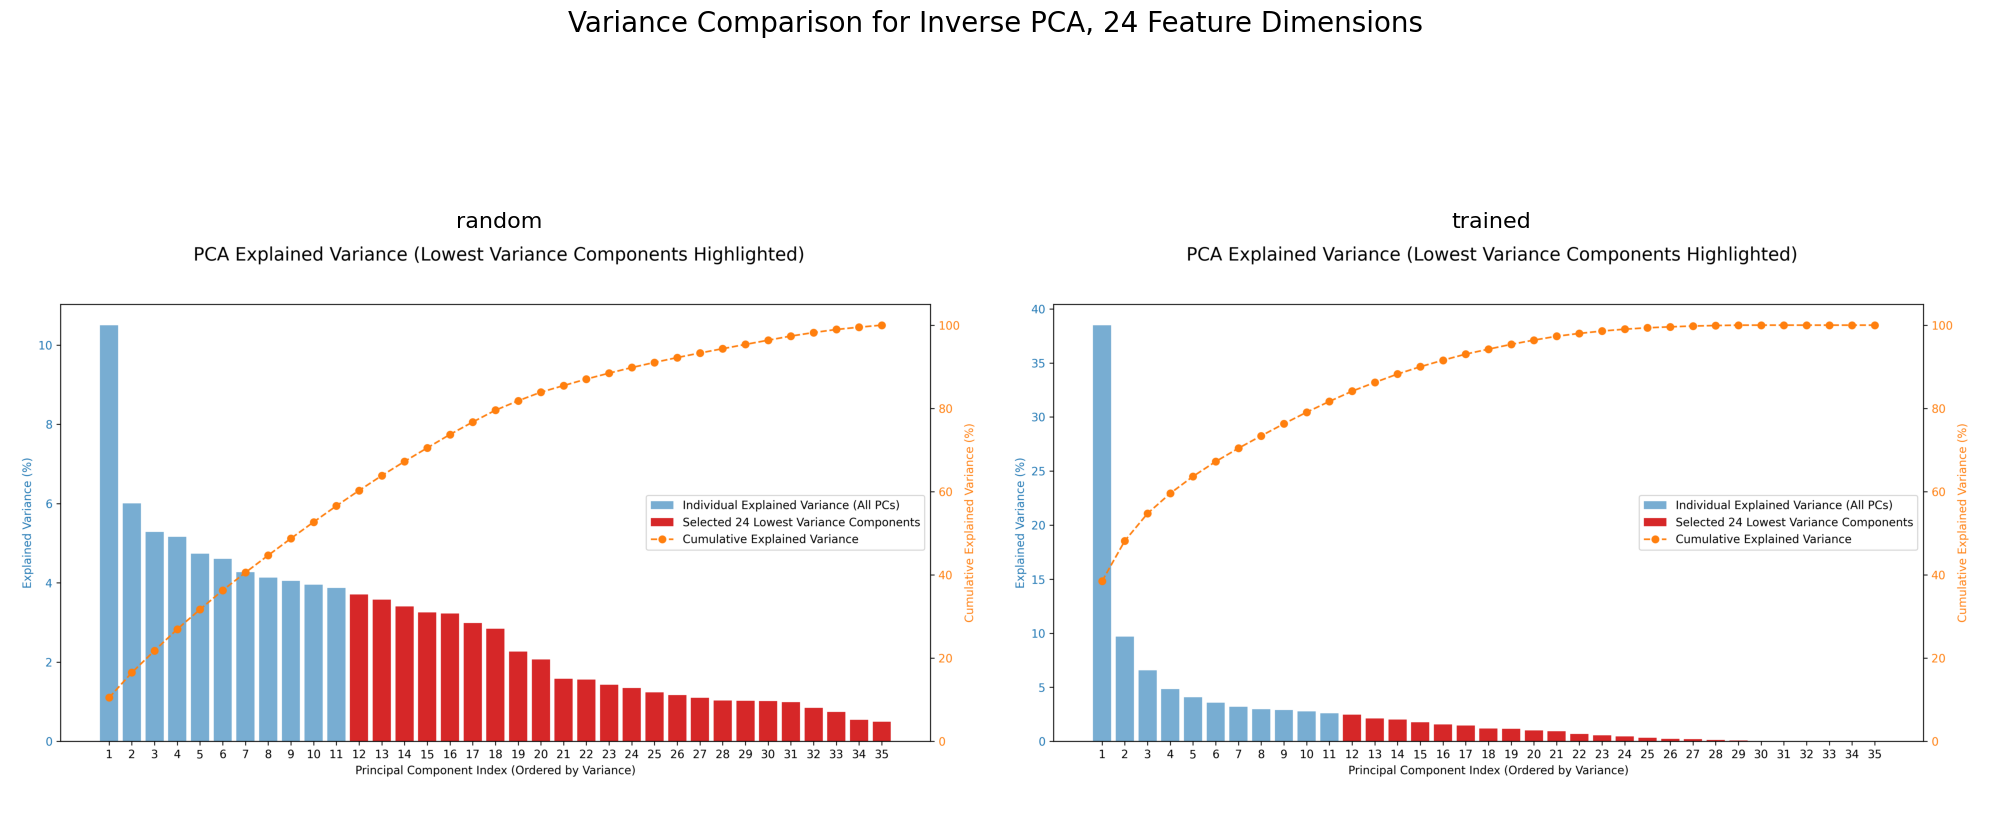

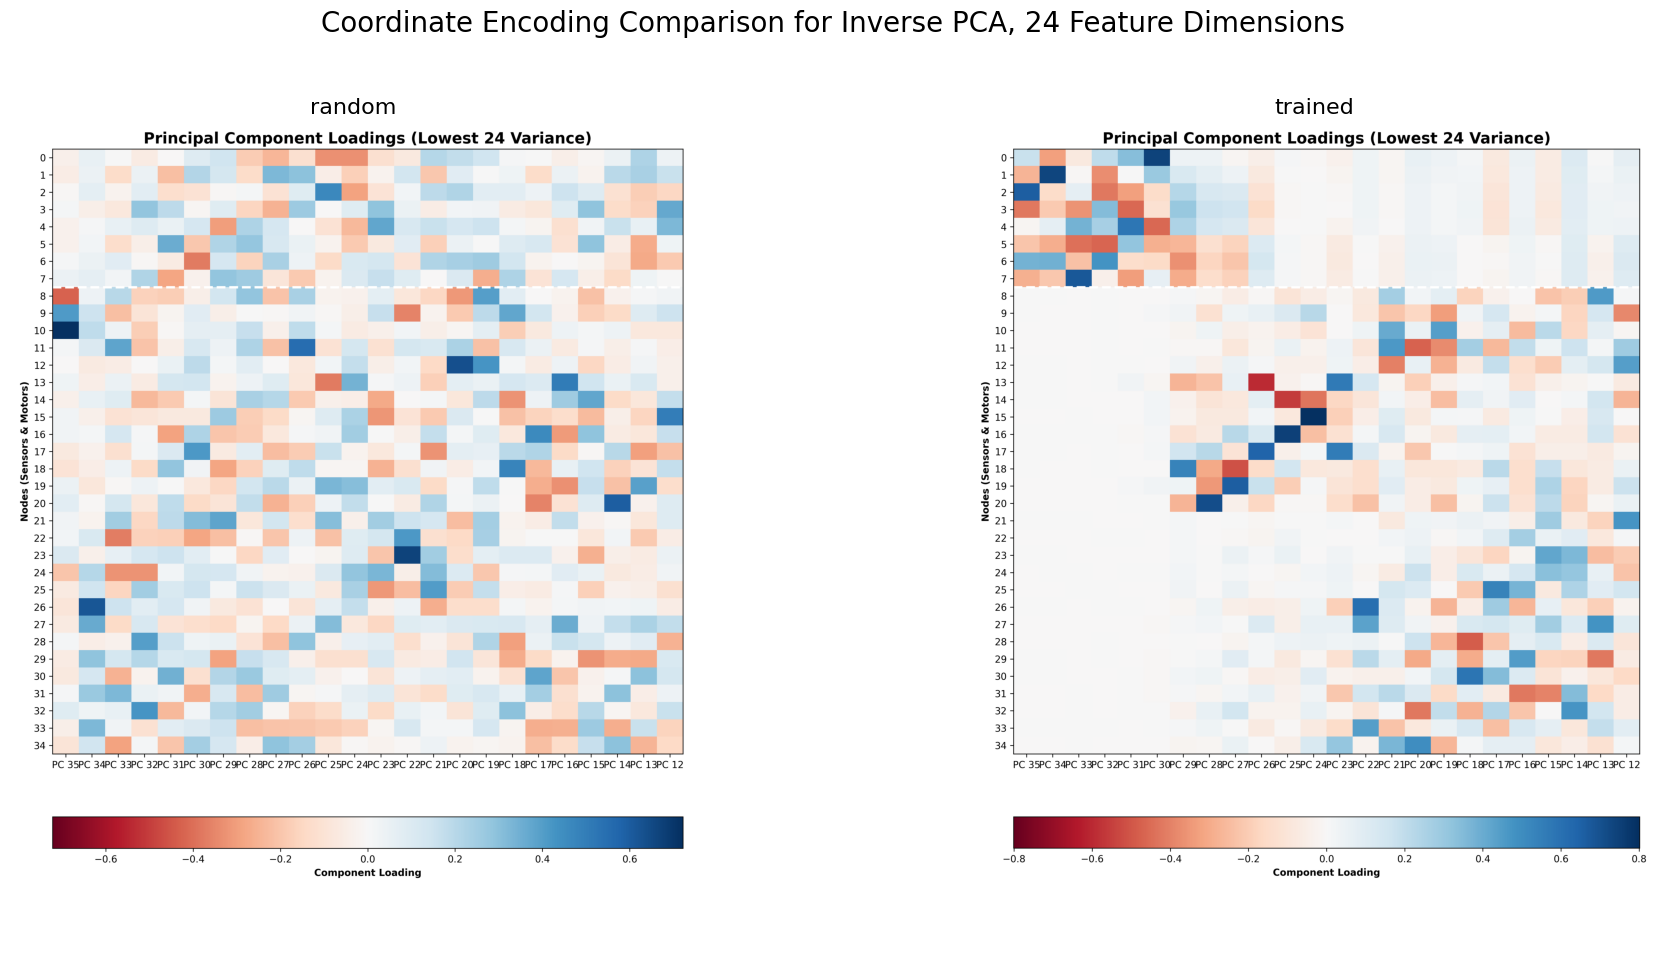

In [8]:
for feature_dims in feature_dims_repeats:    
    for data_label, data_array in data_sources.items():

        print(f"Analyzing {data_label} sampling data with PCA")
        analyzer_inv_pca = InvPCAanalyzer(
            data=data_array, 
            obs_size=obs_size, 
            act_size=act_size,
            feature_dims=feature_dims,
            width_factor=config["substrate"]["width_factor"],
            normalize_coors=config["data_analysis"]["normalize_coors"],
            depth_factor=config["substrate"]["depth_factor"],
        )
        input_coors_inv_pca, output_coors_inv_pca = analyzer_inv_pca.generate_io_coordinates()
        generated_io_coors[data_label][f"inv_pca"][f"{feature_dims}fd"]["input_coors"] = input_coors_inv_pca
        generated_io_coors[data_label][f"inv_pca"][f"{feature_dims}fd"]["output_coors"] = output_coors_inv_pca
        analyzer_inv_pca.plot_least_variance_components(save_path=f"{OUTPUT_DIR}/data_analysis/inv_pca_{data_label}_{feature_dims}fd.png")
        analyzer_inv_pca.plot_principal_components(save_path=f"{OUTPUT_DIR}/data_analysis/inv_pca_heatmap_{data_label}_{feature_dims}fd.png")
        print("\n")


    display_plots_side_by_side(
        plot_paths=[f"{OUTPUT_DIR}/data_analysis/inv_pca_random_{feature_dims}fd.png", f"{OUTPUT_DIR}/data_analysis/inv_pca_trained_{feature_dims}fd.png"],
        plot_titles=["random", "trained"],
        main_title=f"Variance Comparison for Inverse PCA, {feature_dims} Feature Dimensions",
        save_path=f"{OUTPUT_DIR}/data_analysis/inv_pca_variance_comparison_{feature_dims}fd.png"
    )
    display_plots_side_by_side(
        plot_paths=[f"{OUTPUT_DIR}/data_analysis/inv_pca_heatmap_random_{feature_dims}fd.png", f"{OUTPUT_DIR}/data_analysis/inv_pca_heatmap_trained_{feature_dims}fd.png"],
        plot_titles=["random", "trained"],
        main_title=f"Coordinate Encoding Comparison for Inverse PCA, {feature_dims} Feature Dimensions",
        save_path=f"{OUTPUT_DIR}/data_analysis/inv_pca_heatmap_comparison_{feature_dims}fd.png"
    )

### Factor Analysis

Next, the data is analysed through factor analysis.

Analyzing trained sampling data
Running Factor Analysis to find 24 latent factors...
Factor Analysis complete. Extracting coordinates (factor loadings).
Normalizing coordinates...
Added layering dimension. Final coordinate size: 25
Factor loadings heatmap saved to: output_substrates/data_analysis/fa_heatmap_trained_24fd.png


Analyzing random sampling data
Running Factor Analysis to find 24 latent factors...
Factor Analysis complete. Extracting coordinates (factor loadings).
Normalizing coordinates...
Added layering dimension. Final coordinate size: 25
Factor loadings heatmap saved to: output_substrates/data_analysis/fa_heatmap_random_24fd.png




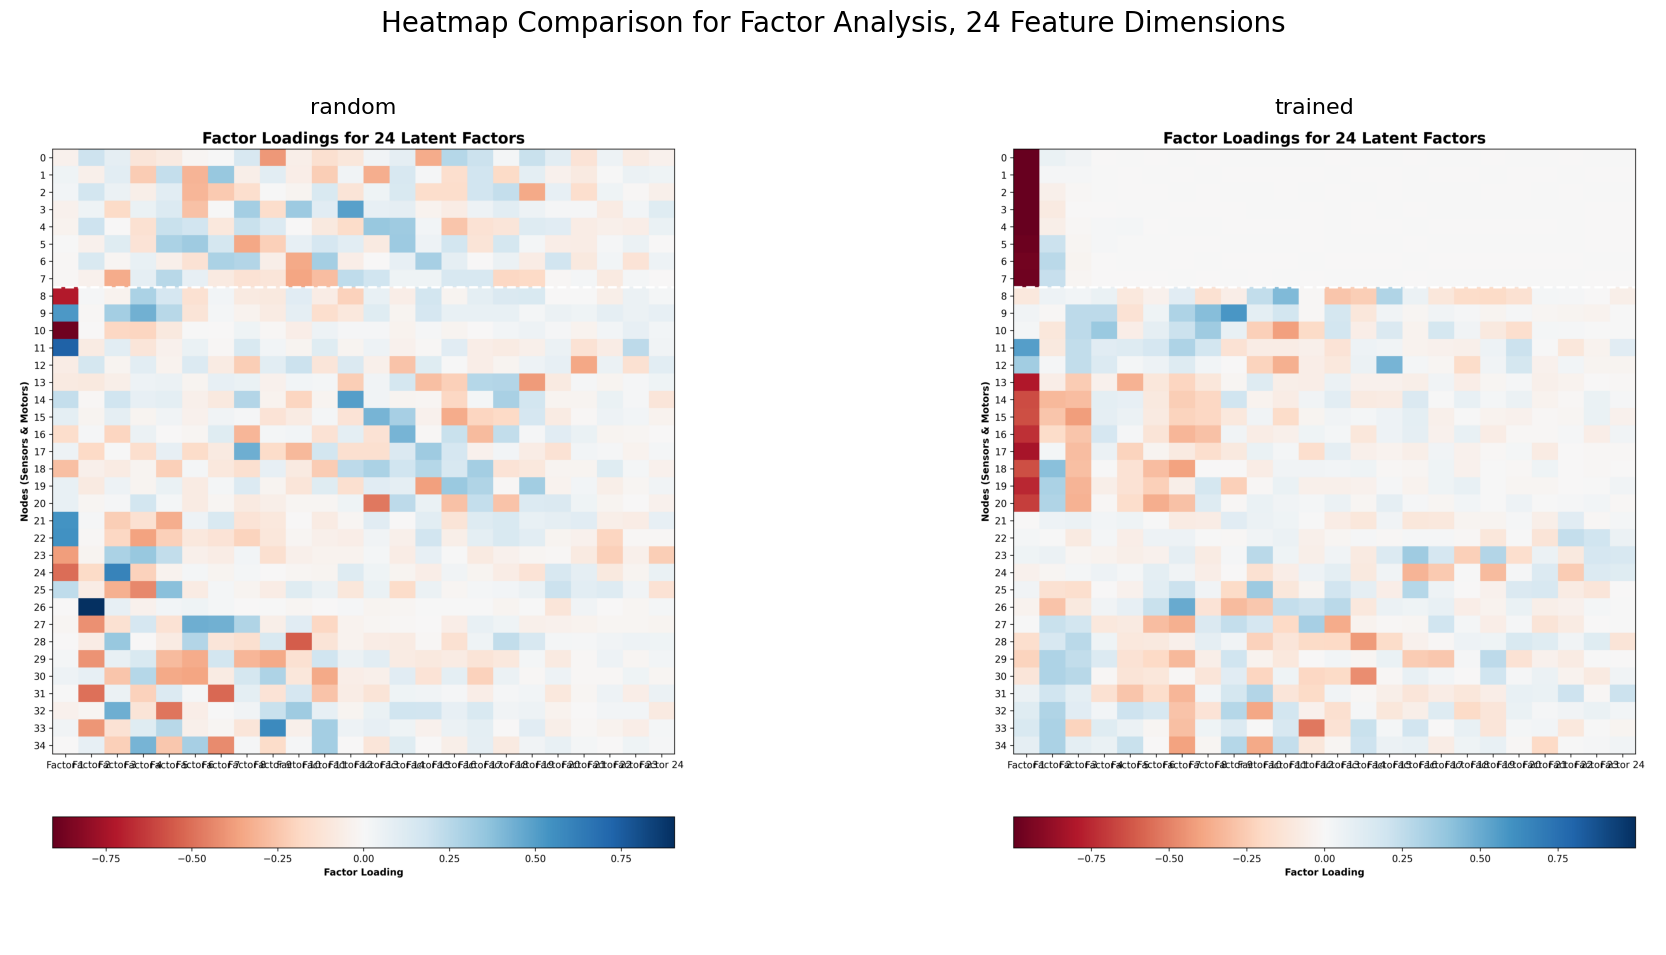

In [9]:
for feature_dims in feature_dims_repeats:  
    for data_label, data_array in data_sources.items():
        print(f"Analyzing {data_label} sampling data")
        analyzer_fa = FactorAnalyzer(
            data=data_array, 
            obs_size=obs_size, 
            act_size=act_size,
            feature_dims=feature_dims,
            width_factor=config["substrate"]["width_factor"],
            normalize_coors=config["data_analysis"]["normalize_coors"],
            depth_factor=config["substrate"]["depth_factor"],
        )
        input_coors_fa, output_coors_fa = analyzer_fa.generate_io_coordinates()
        generated_io_coors[data_label]["fa"][f"{feature_dims}fd"]["input_coors"] = input_coors_fa
        generated_io_coors[data_label]["fa"][f"{feature_dims}fd"]["output_coors"] = output_coors_fa
        analyzer_fa.plot_factor_loadings(save_path=f"{OUTPUT_DIR}/data_analysis/fa_heatmap_{data_label}_{feature_dims}fd.png")
        print("\n")

    display_plots_side_by_side(
        plot_paths=[f"{OUTPUT_DIR}/data_analysis/fa_heatmap_random_{feature_dims}fd.png", f"{OUTPUT_DIR}/data_analysis/fa_heatmap_trained_{feature_dims}fd.png"],
        plot_titles=["random", "trained"],
        main_title=f"Heatmap Comparison for Factor Analysis, {feature_dims} Feature Dimensions",
        save_path=f"{OUTPUT_DIR}/data_analysis/fa_heatmap_comparison_{feature_dims}fd.png"
    )

### Dictionary Learning

Lastly, Dictionary Learning is also applied to the data.

Analyzing trained sampling data
Running Dictionary Learning to find 24 dictionary atoms...
DL complete. Extracting coordinates (loadings on dictionary atoms).
Normalizing coordinates...
Added layering dimension. Final coordinate size: 25
Dictionary atoms heatmap saved to: output_substrates/data_analysis/dl_heatmap_trained_24fd.png


Analyzing random sampling data
Running Dictionary Learning to find 24 dictionary atoms...


/home/andi/anaconda3/envs/jax/lib/python3.10/site-packages/sklearn/linear_model/_least_angle.py:753: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 4 iterations, alpha=4.066e-02, previous alpha=4.057e-02, with an active set of 5 regressors.
  warnings.warn(


DL complete. Extracting coordinates (loadings on dictionary atoms).
Normalizing coordinates...
Added layering dimension. Final coordinate size: 25
Dictionary atoms heatmap saved to: output_substrates/data_analysis/dl_heatmap_random_24fd.png




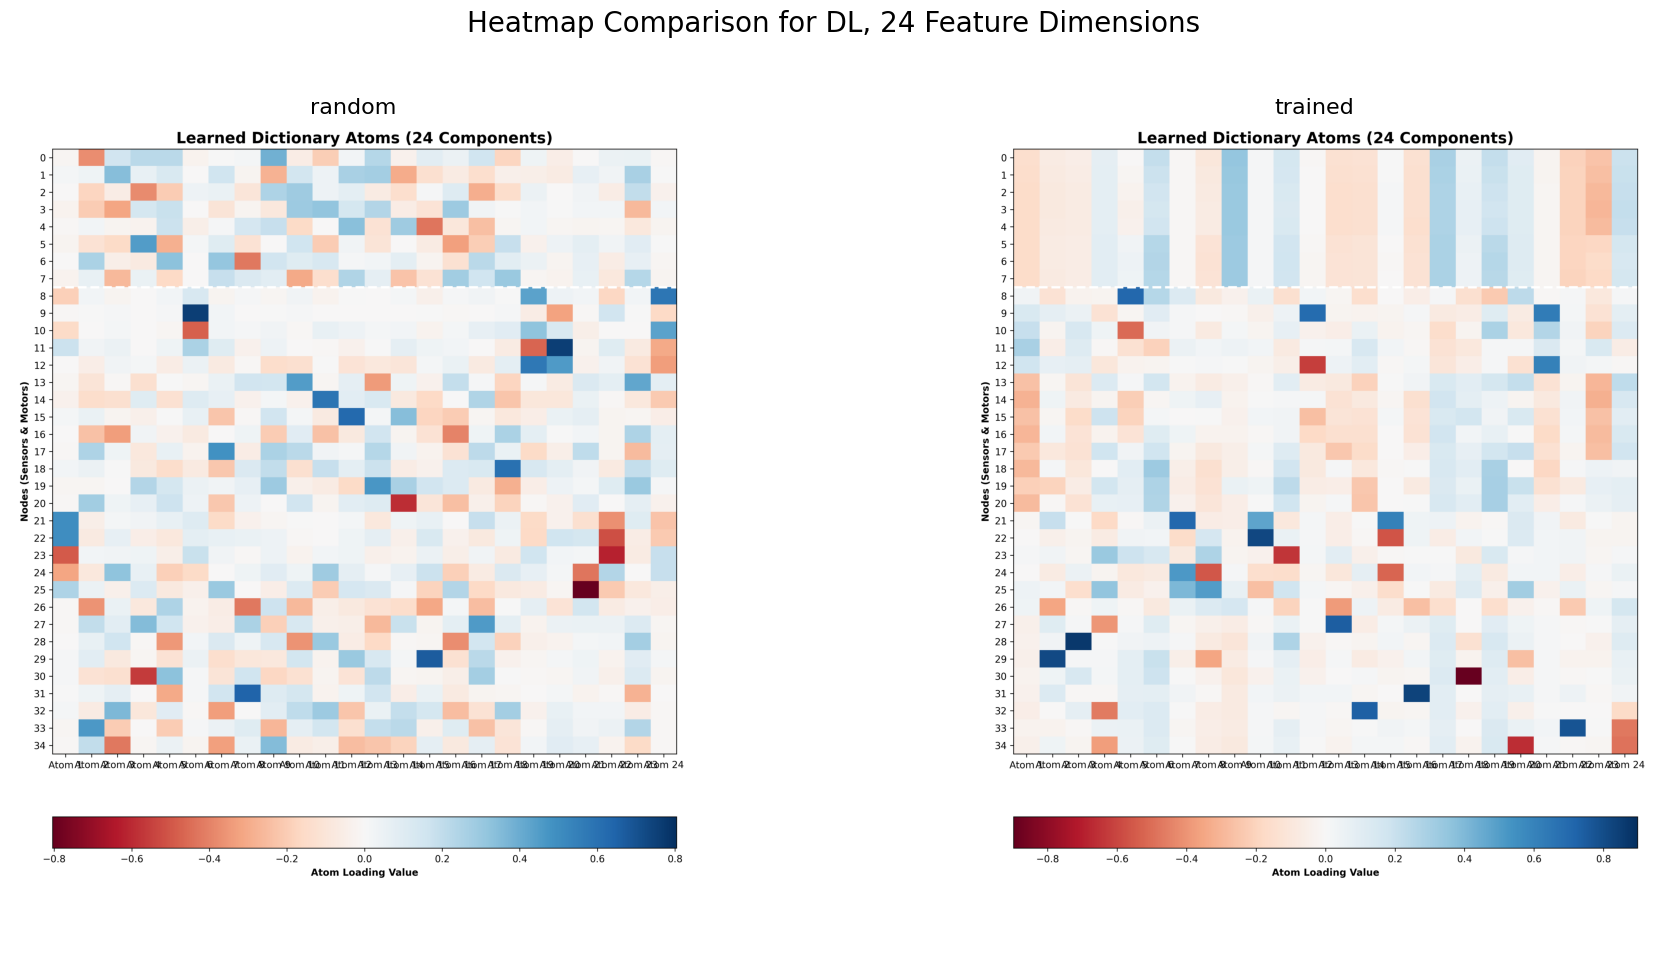

In [10]:
for feature_dims in feature_dims_repeats:  
    for data_label, data_array in data_sources.items():
        print(f"Analyzing {data_label} sampling data")
        analyzer_dl = DictionaryAnalyzer(
            data=data_array,
            obs_size=obs_size,
            act_size=act_size,
            feature_dims=feature_dims,
            alpha=config["data_analysis"]["dl_alpha"],
            max_iter=config["data_analysis"]["dl_max_iter"],
            width_factor=config["substrate"]["width_factor"],
            normalize_coors=config["data_analysis"]["normalize_coors"],
            depth_factor=config["substrate"]["depth_factor"],
        )
        input_coors_dl, output_coors_dl = analyzer_dl.generate_io_coordinates()
        generated_io_coors[data_label]["dl"][f"{feature_dims}fd"]["input_coors"] = input_coors_dl
        generated_io_coors[data_label]["dl"][f"{feature_dims}fd"]["output_coors"] = output_coors_dl
        analyzer_dl.plot_dictionary_atoms(save_path=f"{OUTPUT_DIR}/data_analysis/dl_heatmap_{data_label}_{feature_dims}fd.png")
        print("\n")

    display_plots_side_by_side(
        plot_paths=[f"{OUTPUT_DIR}/data_analysis/dl_heatmap_random_{feature_dims}fd.png", f"{OUTPUT_DIR}/data_analysis/dl_heatmap_trained_{feature_dims}fd.png"],
        plot_titles=["random", "trained"],
        main_title=f"Heatmap Comparison for DL, {feature_dims} Feature Dimensions",
        save_path=f"{OUTPUT_DIR}/data_analysis/dl_heatmap_comparison_{feature_dims}fd.png"
    )

## Substrate Generation

Now it's time to generate the full substrates. The input and ouput nodes have already been generated above, so the hidden layers are the crucial part that's missing.

### Generating Hidden Layers

A `HiddenLayerGenerator` class is used to generate hidden nodes from the input node. There are of course, many ways these hidden nodes can be defined in the high-dimensional space. The class has a few options hard-coded:

* `one_hot_binary`: This does a one-hot encoding of the dimensions, so there will be one coordinate for each dimension. E.g. for 3 Dimensions: (1,0,0),(0,1,0),(0,0,1)
* `one_hot_ternary`: This does a one-hot encoding of the dimensions which also includes negatives, so there will be one coordinate for each dimension. E.g. for 3 Dimensions: (1,0,0),(0,1,0),(0,0,1),(-1,0,0),(0,-1,0),(0,0,-1)
* `one_double_hot_binary`: This is the same as one-hot, but has two coordinates in every dimension, e.g. for 3 dimensions: (1,0,0),(0,1,0),(0,0,1),(2,0,0),(0,2,0),(0,0,2)
* `two_hot_binary`: This adds all possible pairs of dimensions as coordinates to the one_hor ecoding, e.g. for 3 dimensions: (1,0,0),(0,1,0),(0,0,1),(1,1,0),(1,0,1),(0,1,1)
* `shift`: This schema takes all input nodes and simply "shifts" every one of them into the layering direction by 1 for each layer.
* `shift_two_out`: This does the same as `shift`, but doubles the number of nodes by adding duplicates outside the bounds of the original nodes by adding the width_factor which determines the outer bounds of the dimensions.
* `shift_three_out`: This does the same as `shift_double_out`, but adds another set of duplicates of the original nodes with double the distance than before.
* `shift_two_in`: This does the same as `shift`, but doubles the number of nodes by adding duplicates inside the bounds of the original nodes by dividing the coordinates in each dimension by 2.
* `shift_three_in`: This does the same as `shift_double_in`, but adds another set of duplicates of the original where the nodes in each dimension are positioned at 1/3, 2/3 and full distance.

So `shift_*_in` increases the resolution while `shift_*_out` extends the network outwards.

One important thing to notice is that the number of generated hidden nodes is highly dependent on the number of dimensions (one_hot/one_double_hot linear and two_hot exponential), except for the `shift`-based methods.

In [11]:
hidden_layer_gen = HiddenLayerGenerator(
    env_name=env_name,
    obs_size=obs_size,
    act_size=act_size,
    hidden_layer_type=config["substrate"]["hidden_layer_type"],
    hidden_depth=config["substrate"]["hidden_depth"],
    depth_factor=config["substrate"]["depth_factor"],
    width_factor=config["substrate"]["width_factor"],
)

In [12]:
substrates = deep_defaultdict()

### Random Substrate

We also want to test if our data-driven approaches are better than arbritarily chosen coordinates in an equally high-dimensional space. For this purpose the generator creates a substrate with the given number of dimensions in which all coordinates are random binary combinations, e.g. (0,1,0,1,1,0). If the target number of coordinates can't be created from unique binary combinations, the generator uses terniary combinations of 0, 0.5, 1. If that also fails to generate the required number of coordinates, if falls back to continous random numbers.

In [13]:
for feature_dims in feature_dims_repeats:  
    random_generator = RandomCoordinateGenerator(
        obs_size=obs_size,
        act_size=act_size,
        feature_dims=feature_dims,
        depth_factor=config["substrate"]["depth_factor"],
        width_factor=config["substrate"]["width_factor"],
    )
    input_coors_random, output_coors_random = random_generator.generate_io_coordinates()
    generated_io_coors["no_data"]["random_coors"][f"{feature_dims}fd"]["input_coors"] = input_coors_random
    generated_io_coors["no_data"]["random_coors"][f"{feature_dims}fd"]["output_coors"] = output_coors_random

Generating random coordinates with 24 feature dimensions...
Added layering dimension. Final coordinate size: 25


### Substrate from Data Analysis Results

Next, the input and output nodes created through data analysis are used to create substrates.

In [14]:
for data_label, data_dict in generated_io_coors.items():
    for method_label, method_dict in data_dict.items():
        for feature_dims_label, feature_dims_dict in method_dict.items():
            input_coors = feature_dims_dict["input_coors"]
            output_coors = feature_dims_dict["output_coors"]
            hidden_coors = hidden_layer_gen.get_hidden_coors(input_coors=input_coors)
            generated_io_coors[data_label][method_label][feature_dims_label]["hidden_coors"] = hidden_coors

            substrates[data_label][method_label][feature_dims_label]["substrate"] = FullSubstrate(
                input_coors=input_coors,
                hidden_coors=hidden_coors,
                output_coors=output_coors
            )

            substrates[data_label][method_label][feature_dims_label]["input_coors"] = input_coors
            substrates[data_label][method_label][feature_dims_label]["hidden_coors"] = hidden_coors
            substrates[data_label][method_label][feature_dims_label]["output_coors"] = output_coors

            # all input and output coordinates are logged for further analysis
            log_coors = [*input_coors, *hidden_coors, *output_coors]
            save_coordinates_to_csv(
                coordinates=log_coors,
                filepath=f"{OUTPUT_DIR}/coordinates/{data_label}_{method_label}_{feature_dims_label}_io.csv",
            )


Successfully saved coordinates to: output_substrates/coordinates/trained_ica_24fd_io.csv
Successfully saved coordinates to: output_substrates/coordinates/trained_pca_24fd_io.csv
Successfully saved coordinates to: output_substrates/coordinates/trained_inv_pca_24fd_io.csv
Successfully saved coordinates to: output_substrates/coordinates/trained_fa_24fd_io.csv
Successfully saved coordinates to: output_substrates/coordinates/trained_dl_24fd_io.csv
Successfully saved coordinates to: output_substrates/coordinates/random_ica_24fd_io.csv
Successfully saved coordinates to: output_substrates/coordinates/random_pca_24fd_io.csv
Successfully saved coordinates to: output_substrates/coordinates/random_inv_pca_24fd_io.csv
Successfully saved coordinates to: output_substrates/coordinates/random_fa_24fd_io.csv
Successfully saved coordinates to: output_substrates/coordinates/random_dl_24fd_io.csv
Successfully saved coordinates to: output_substrates/coordinates/no_data_random_coors_24fd_io.csv


The substrates are saved to disk to use in other notebooks.

In [15]:
with open("substrates_d25.pkl", "wb") as f:
    pickle.dump(substrates, f)